In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
import re
import jieba

%matplotlib inline

In [2]:
#讀入訓練及測試用的留言庫

X_train, Y_train = read_csv('data/train_emoji_ch.csv')
X_test, Y_test = read_csv('data/tesss_ch.csv')

In [3]:
#測試emoji的參數
label_to_emoji(7)

'😡'

In [4]:
#計算訓練留言庫中最長的句子及分割字詞示範

text=max(X_train, key=len)
text = list(jieba.cut(text,cut_all=False))
maxLen = len(text)


maxLen=18  #後面再切碎字串，這裡用最大的
print(maxLen)
text

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/bv/2q78w3811yg71lmsppx6lxrw0000gn/T/jieba.cache
Loading model cost 0.947 seconds.
Prefix dict has been built succesfully.


18


['我', '的', '程式', '明明', '可以', '執行', '但', '導師', '仍給', '我', '零分']

In [5]:
#閱讀訓練留言庫的留言
index = 7
print(X_train[index], label_to_emoji(Y_train[index]))

這功課太多了 😞


In [6]:
Y_oh_train = convert_to_one_hot(Y_train, C = 8)
Y_oh_test = convert_to_one_hot(Y_test, C = 8)

In [7]:
#將訓練留言的正確答案化為one hot 陣列
index = 0
print(Y_train[index], "is converted into one hot", Y_oh_train[index])

3 is converted into one hot [0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
#讀入facebook預先訓練好的中文文字向量
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/wiki.zh.vec')

In [9]:
#讀入文字向量中單詞的數據
word = "差"
index = 235052
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])
len(word_to_vec_map[word])

the index of 差 in the vocabulary is 235052
the 235052th word in the vocabulary is 差


300

In [10]:
#加總留言字詞向量

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.

    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation

    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """


    words = list(jieba.cut(sentence,cut_all=False))
    temps=[]
    for w in words:
        try:
            word_to_vec_map[w]
            temp=w
        except:
            temp=list(w)
        temps.append(temp)
    flat_list=[]
    _ = [flat_list.extend(item) if isinstance(item, list) else flat_list.append(item) for item in temps if item]
    while ' ' in flat_list:
        flat_list.remove(' ')
    words=flat_list

    avg = np.zeros((300,))

    for w in words:
        avg += word_to_vec_map[w]
    avg = avg/len(words)


    return avg

In [11]:
#測試把留言的字詞向量加總及平均

avg = sentence_to_avg("這是我一生最差勁的一天 ", word_to_vec_map)
print("avg = ", avg)

avg =  [-1.13861875e-01  1.04477125e+00 -5.89520000e-01  3.24456250e-01
  7.38658750e-01 -4.64008750e-01 -5.60848750e-01  2.58263750e-02
  4.23486250e-01 -1.34124125e-01  9.67411250e-01  1.42290625e-01
  1.35261125e+00 -9.27590000e-01  2.08043500e-01 -6.24710000e-01
  9.57933750e-01 -4.19742250e-01 -1.12124625e+00 -6.56251250e-01
 -9.99676250e-01  1.06239875e+00  1.18810875e+00  8.31875000e-03
  5.75907500e-01 -4.11583750e-01  9.39983750e-01  1.99731000e-01
  7.24997500e-01  2.47968175e-01  7.64845000e-01 -1.00287625e+00
 -9.05686250e-01 -5.49693750e-01 -8.29576250e-01  1.19548875e+00
  1.05869750e+00 -5.47840000e-01  1.93496250e-01  1.26827750e+00
  7.34667500e-01  1.07951875e+00  1.17510625e+00 -1.09544750e+00
 -3.72637425e-01 -4.29343750e-01 -7.19981250e-01 -3.67023750e-01
  5.13111375e-01 -8.94367500e-01  1.25980625e+00 -3.23177875e-01
 -3.98428750e-01 -3.33925750e-01  4.74337750e-02 -9.53198750e-01
 -1.10110875e+00 -1.26326375e+00 -3.35262500e+00  3.98726250e-01
  1.14972250e+00 -

In [12]:
#模型參數 learning_rate 及 num_iterations均可以修改

def model(X, Y, word_to_vec_map, learning_rate = 0.005, num_iterations = 1000):
    """
    Model to train word vector representations in numpy.

    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations

    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    np.random.seed(1)


    m = Y.shape[0]                          # number of training examples
    n_y = 8                                 # number of classes  
    n_h = 300                               # dimensions of the GloVe vectors 


    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))


    Y_oh = convert_to_one_hot(Y, C = n_y) 


    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            # Average the word vectors of the words from the j'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)
            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)
            # Compute cost using the j'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(Y_oh[i] * np.log(a))

            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
         
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [13]:
#訓練模型
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 2.838557314655528
Accuracy: 0.059602649006622516
Epoch: 100 --- cost = 1.208787957239081
Accuracy: 0.5960264900662252
Epoch: 200 --- cost = 0.619723973651847
Accuracy: 0.7218543046357616
Epoch: 300 --- cost = 0.4027164591549059
Accuracy: 0.7682119205298014
Epoch: 400 --- cost = 0.3002130588259839
Accuracy: 0.8013245033112583
Epoch: 500 --- cost = 0.23925132641522678
Accuracy: 0.8211920529801324
Epoch: 600 --- cost = 0.19674781080695078
Accuracy: 0.8609271523178808
Epoch: 700 --- cost = 0.1649123704857175
Accuracy: 0.8807947019867549
Epoch: 800 --- cost = 0.14047599147368353
Accuracy: 0.9139072847682119
Epoch: 900 --- cost = 0.12151579557825612
Accuracy: 0.9403973509933775
[[3.]
 [2.]
 [3.]
 [0.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [7.]
 [0.]
 [2.]
 [2.]
 [4.]
 [2.]
 [2.]
 [0.]
 [7.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [7.]
 [7.]
 [4.]
 [2.]
 [1.]

In [14]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9536423841059603
Test set:
Accuracy: 0.5882352941176471


In [15]:
#輸入多個留言看結果
X_my_sentences = np.array(["政府可恥", "我憎恨你", "這位同學是白癡", "曼聯快搶攻", "真想吃薯條", "我可不可以去廁所"])
Y_my_labels = np.array([[7], [7], [2], [1], [4],[6]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.6666666666666666

政府可恥 😡
我憎恨你 😞
這位同學是白癡 😄
曼聯快搶攻 ⚾
真想吃薯條 🍴
我可不可以去廁所 😡


In [16]:
#輸入單詞看結果

my_sentence="我訂了三文魚"
X_my_sentences = np.array([my_sentence])
#Y_my_labels = np.array([[1]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.16666666666666666

我訂了三文魚 🍴


(51,)
           ❤️    ⚾    😄    😞   🍴   😭   💩   😡
Predicted  0.0  1.0  2.0  3.0  4.0  7.0  All
Actual                                      
0            6    0    0    0    1    0    7
1            1    4    0    0    0    1    6
2            5    0    7    2    0    4   18
3            1    1    1    8    0    3   14
4            0    0    1    0    5    0    6
All         13    5    9   10    6    8   51


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:7460: RuntimeWarning: '<' not supported between instances of 'str' and 'float', sort order is undefined for incomparable objects
  return_indexers=True)


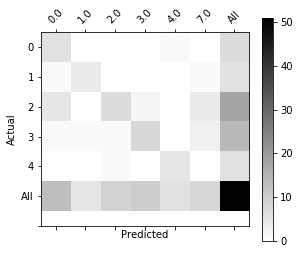

In [17]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4)+'   ' + label_to_emoji(5)+'   ' + label_to_emoji(6)+'   ' + label_to_emoji(7))
print(pd.crosstab(Y_test, pred_test.reshape(51,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [18]:
#輸入gensim，看文字向量的關連性

from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format("data/wiki.zh.vec", binary = False)

In [19]:
word_vectors.most_similar('小貓', topn = 10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('愛犬', 0.9518550038337708),
 ('花貓', 0.9500274062156677),
 ('養貓', 0.9474766850471497),
 ('貓', 0.947167158126831),
 ('貓咪', 0.9470548033714294),
 ('小臉', 0.9433143734931946),
 ('猴兒', 0.9423208236694336),
 ('貓叫', 0.9421137571334839),
 ('小輩', 0.9417970180511475),
 ('柴犬', 0.9417864680290222)]

In [20]:
word_vectors.similarity("電視", "劉德華")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.85784405